Code written to test my theory of how to calculate the B field applied to a NV centre using the 11 point measurement procedure. 


In [42]:
import scipy.optimize as opt 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plot 


In [43]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

In [44]:
def find_straight_lines(y_fit, res_freqs, freq):
    # A method to find the stright portion of the ODMR fittings. 
    positions = []
    print(np.where(freq == res_freqs[0])[0])
    # find the index of the ODMR minima
    positions.append(0)
    positions.append(int( np.where(freq == res_freqs[0])[0]))
    positions.append(int( np.where(freq == 2.870)[0]))
    positions.append(int( np.where(freq == res_freqs[1])[0]))
    positions.append(len(freq)-1)
    minima_limit = np.zeros([2,1])
    
    minima_limit[0,0] = 1.005*y_fit[positions[1]]
    minima_limit[1,0] = 1.005*y_fit[positions[3]]
    maxima_limit = 0.98*np.mean(y_fit)
    
    a = 0
    df = pd.DataFrame(columns=["0", "1", "2", "3"])
    x=[]
    
    for i in range(len(positions)-1):
        for j in range(positions[i+1]-positions[i]):
            
            if y_fit[positions[i]+j] >= minima_limit[a,0] and y_fit[positions[i]+j] <= maxima_limit:
                x.append(positions[i]+j)
        
        df[str(i)] = pd.Series(x)
        x = [] 
        if i == 1:
            a = 1
            
    return(df)

In [97]:
def find_linear_fits(df, freq, y_fit):
    # finds the linear fits and plots them and finds the r2 values for each 
    
    #initalises local variables
    init_params = [1,1]
    fit_params = np.zeros([len(df.columns), 2])
    fit_errors = np.zeros([len(df.columns), 2])
    
    fig4, ax4 = plot.subplots()
    therm_freqs_index = []
    therm_freqs = []
    r_squared = []
    
    # plot lorentz fitting
    ax4.plot(freq, y_fit, color = 'k', label='Lorentz fit')
    
    # a loop to generate the straight line fits for the ODMR dips. 
    # Also finds the 4 frequency points usedd for each curve for 
    # thermometry and the r_squared values for the linear fits. 
    for i in range(len(df.columns)):
        # indicies corresponding to the linear portions of the 
        # lorentz fittings.
        indicies = np.array(df[str(i)])
        indicies = indicies[~np.isnan(indicies)].astype(int)
        # Preform linear fit
        fit, confidence = opt.curve_fit(straight_line_fit, freq[indicies], y_fit[indicies], init_params)
        fit_errors[i,:] = np.sqrt(np.diag(confidence))
        fit_params[i,:] = fit
            
        #create linear fit and plot
        y = straight_line_fit(freq[indicies], fit[0], fit[1])
        ax4.plot(freq[indicies], y, linewidth = 2, color = 'r')

        # find the r_squared value for the linear fit. 
        r_squared.append(get_r_squared(freq[indicies], y_fit[indicies], y))
        
        # find the 4 frequency points for each peak and plot
        therm_freqs_index.append(get_4_freq_indicies(y))
        ax4.scatter(freq[indicies][therm_freqs_index[i]], y[therm_freqs_index[i]], 
                    color = 'k', marker = 'x', linewidth = 2)
        
        therm_freqs.append(np.round(freq[indicies][therm_freqs_index[i][0]],6))
        therm_freqs.append(np.round(freq[indicies][therm_freqs_index[i][1]],6))
    
    ax4.plot(freq[indicies], y, linewidth = 2, label='Linear Fit',
                color = 'r')
    ax4.scatter(freq[indicies][therm_freqs_index[i]], y[therm_freqs_index[i]], 
                    color = 'k', marker = 'x', label = '8 measurement \npoints')
    
    ax4.set_xlabel('Microwave Frequency (GHz)')
    ax4.set_ylabel('Counts per 1ms')
    ax4.legend()

    return(fig4, ax4, therm_freqs, fit_params, fit_errors, r_squared)

In [46]:
def straight_line_fit(x, m, c):
    # creates a staight line fit 
    y = m*x + c
    return(y)

In [47]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

In [48]:
def get_4_freq_indicies(linear_fit):
    # This is the method to find the index in the lienar fits for the
    # 4 frequency points to be used for 4 point thermometry. 
    
    array_length = len(linear_fit)
    
    mid_point = np.floor(array_length/2) 
    delta_f_index = np.floor(array_length/4) 
    
    f_minus = int(mid_point-delta_f_index)
    f_plus = int(mid_point+delta_f_index)
    f_mid = int(mid_point)
    
    return([f_minus, f_plus])
    

In [78]:
# make plots actually large enough to see.
plot.rcParams.update({'font.size' : 20})
plot.rcParams.update({'figure.figsize' :[12, 8]})


In [79]:
def delta_B(I_plus, I_minus, m):
   # Calculate the change in magnetic field from the Intensity measurements 
    # of the 4 frequencies. 
    
    #Constants
    h_bar = 6.64*10**-34
    bohr = 9.27*10**-24
    g_e = 2.002
    
    delta_B = (h_bar/(2*bohr*g_e))*((I_plus-I_minus)/(4*m))
    
    return(delta_B)

[3200]


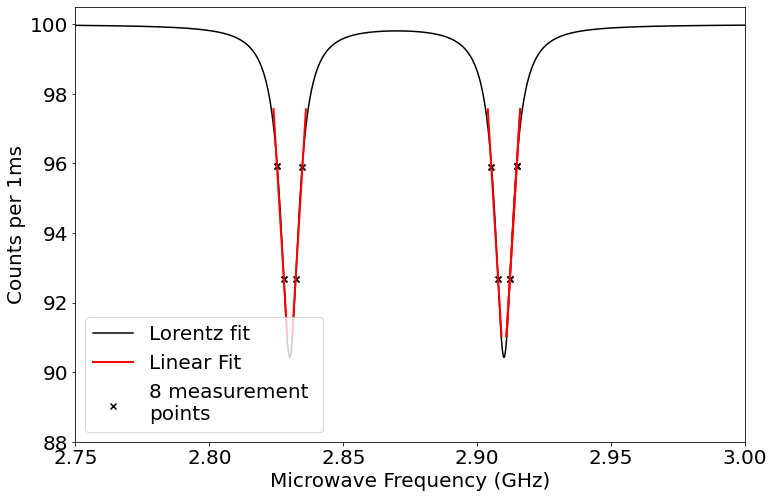

In [98]:
# Set plot 1 (initial condition) parameters
x0 = 2.83
x1 = 2.91
A1 = -30
A2 = -30
sig1 = 0.008
sig2 = 0.008
offset = 100 

# Generate double lorenzian plot. 
res_freqs = np.array([x0, x1])
x = np.linspace(2.75, 3.00, 10001)
y1 = double_lorentz(x, A1, x0, sig1, A2, x1, sig2, offset)
# Find the linear portions of the lorentian dips.
linear_ODMR = find_straight_lines(y1, res_freqs, x)
# Extract:
# the frequencies used for measurement, 
# The linear fitting parameters. 
# The goodness of fit of the linear fits to the lorentz curve
# Plot the graphs. 
fig3, ax3, thermometry_freqs, linear_fit_params, linear_fit_error, r_squared = find_linear_fits(linear_ODMR, x, y1)

# Initial parameters for the "increased B field" case (100kHz difference.)
x3 = 2.8299
x4 = 2.9101
res_freqs = [x3, x3]
A3 = -30
A4 = -30
sig3 = 0.005
sig4 = 0.005
offset2 = 100 

x2 = np.linspace(2.75, 3.00, 10001)
y2 = double_lorentz(x2, A3, x3, sig3, A4, x4, sig4, offset2)
ax3.set_ylim([88, 100.5])
ax3.set_xlim([2.75, 3.00])
#ax3.plot(x2, y2)
fig3.savefig('C:\\Users\\Ryan\\Desktop\\8_point_graph.pdf')

In [81]:
# Extract the intensity values from the second double lorentz fitting 
# for the 4 frequency values f1, f2, f5, f6. 

indices = [] 
Is_peak_2 = []
for i in range(len(thermometry_freqs)):
    indices.append(np.where(x2 == thermometry_freqs[i])[0])
    Is_peak_2.append(y2[np.where(x2 == thermometry_freqs[i])[0]])

print(Is_peak_2)

[array([97.85042739]), array([94.39240637]), array([94.818329]), array([97.98486094]), array([97.98486094]), array([94.818329]), array([94.39240637]), array([97.85042739])]


In [68]:
# Calculate total fluorescence recorded from two frequnecy points 
# on the two different lorentz dips. 
I_plus = Is_peak_2[0] + Is_peak_2[1]
I_minus = Is_peak_2[4] + Is_peak_2[5]
#extract gradient (assumed to be equal for both peaks.)
m = linear_fit_params[0][0]

# Calculate the change in magnetic field via fluorescence intensity. 
dB = delta_B(I_plus, I_minus, m)


In [69]:
print(dB)

[1.79130607e-15]


In [70]:
# Calculate the increase in B field needed to generate the 100kHz 
# shift in the resonant frequnecy of the NV centre
h_bar = 6.64*10**-34
bohr = 9.27*10**-24
g_e = 2.002

B = (h_bar/(2*bohr*g_e))*0.0001
print(B)

1.7889338277687793e-15
